In [1]:
spark

In [2]:
import pyspark
from delta import *
import pandas as pd
from matplotlib import pyplot as plt
import time

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [3]:
df = spark.sql("""
select dob from delta.`/delta_MIMIC2/d_patients`
""")

age = list(map(lambda dob: int(dob.split('/')[2][:4]), df.toPandas()['dob'].values.tolist()))
from functools import reduce

maxV = reduce(lambda a, b: a if a > b else b, age)
minV = reduce(lambda a, b: a if a < b else b, age)
minV, maxV

(2405, 3498)

In [13]:
spark.sql("""
select sex, count(*) from delta.`/delta_MIMIC2/d_patients` as d_patients
group by sex
""")

sex,count(1)
F,1856
null,13
M,2131


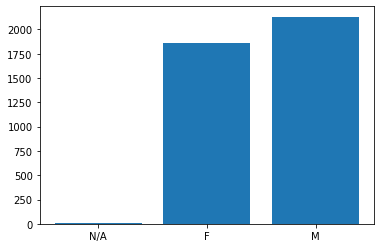

In [4]:
df = spark.sql("""
select sex, count(*) from delta.`/delta_MIMIC2/d_patients` as d_patients
group by sex
""").toPandas().sort_values(by=['count(1)'])
df

x = df['sex'].values.tolist()
x[0] = 'N/A'
y = df['count(1)'].values.tolist()
# print(x)

plt.bar(x,y)
plt.show()

In [5]:
total_patients = spark.sql("""         
SELECT count(*)
FROM delta.`/delta_MIMIC2/d_patients`
""").first()['count(1)']

spark.sql("""select count(*)/{0} as ratioOfDeathInHospital from delta.`/delta_MIMIC2/d_patients` as d_patients
where hospital_expire_flg = 'N'
""".format(total_patients)).show()

+----------------------+
|ratioOfDeathInHospital|
+----------------------+
|               0.58675|
+----------------------+



In [16]:
startT = time.time()
spark.read.format("delta").load("/delta_MIMIC2/demographic_detail").withColumn("hadm_id",pyspark.sql.functions.col("hadm_id").cast("int")).write.format("delta").mode("overwrite").option("overwriteSchema",True).save("/delta_MIMIC2/demographic_detail")
print('Time to overwrite: '+str(time.time()-startT))
        
totalpatientsURGENT = spark.sql("""
select COUNT(*) from
(SELECT ROW_NUMBER() OVER(PARTITION BY subject_id ORDER BY hadm_id desc) 
    AS ROW_NUMBER, subject_id, admission_type_descr from delta.`/delta_MIMIC2/demographic_detail`) tableLastest 
join delta.`/delta_MIMIC2/d_patients` d_patients
on d_patients.subject_id = tableLastest.subject_id where ROW_NUMBER = 1 and admission_type_descr = 'URGENT'
""").first()['count(1)']

patientsURGENTDiedInHospital = spark.sql("""
select COUNT(*) from
(SELECT ROW_NUMBER() OVER(PARTITION BY subject_id ORDER BY hadm_id desc) 
    AS ROW_NUMBER, subject_id, admission_type_descr from delta.`/delta_MIMIC2/demographic_detail`) tableLastest 
join delta.`/delta_MIMIC2/d_patients` d_patients
on d_patients.subject_id = tableLastest.subject_id where ROW_NUMBER = 1 and admission_type_descr = 'URGENT' and hospital_expire_flg = 'Y'
""").first()['count(1)']

print(patientsURGENTDiedInHospital/totalpatientsURGENT)

totalpatientsEMERGENCY = spark.sql("""
select COUNT(*) from
(SELECT ROW_NUMBER() OVER(PARTITION BY subject_id ORDER BY hadm_id desc) 
    AS ROW_NUMBER, subject_id, admission_type_descr from delta.`/delta_MIMIC2/demographic_detail`) tableLastest 
join delta.`/delta_MIMIC2/d_patients` d_patients
on d_patients.subject_id = tableLastest.subject_id where ROW_NUMBER = 1 and admission_type_descr = 'EMERGENCY'
""").first()['count(1)']

patientsEMERGENCYDiedInHospital = spark.sql("""
select COUNT(*) from
(SELECT ROW_NUMBER() OVER(PARTITION BY subject_id ORDER BY hadm_id desc) 
    AS ROW_NUMBER, subject_id, admission_type_descr from delta.`/delta_MIMIC2/demographic_detail`) tableLastest 
join delta.`/delta_MIMIC2/d_patients` d_patients
on d_patients.subject_id = tableLastest.subject_id where ROW_NUMBER = 1 and admission_type_descr = 'EMERGENCY' and hospital_expire_flg = 'Y'
""").first()['count(1)']

print(patientsEMERGENCYDiedInHospital/totalpatientsEMERGENCY)

Time to overwrite: 2.4700443744659424
0.4451219512195122
0.4332077658649667


In [17]:
df = spark.sql("""
select disch_dt, admit_dt, description, drgevents.itemid from delta.`/delta_MIMIC2/drgevents` as drgevents 
join delta.`/delta_MIMIC2/admissions` as admissions
join delta.`/delta_MIMIC2/d_codeditems` as d_codeditems
on d_codeditems.itemid = drgevents.itemid 
and drgevents.hadm_id = admissions.hadm_id
""").toPandas()
df
from datetime import datetime

df["stay_days"] = df["disch_dt"].apply(lambda daytime: datetime.strptime(daytime, '%d/%m/%Y %H:%M:%S')) - df["admit_dt"].apply(lambda daytime: datetime.strptime(daytime, '%d/%m/%Y %H:%M:%S'))
df["stay_days"] = df["stay_days"].apply(lambda timedelta : timedelta.days + 1 if timedelta.seconds//3600 >= 8 else timedelta.days)

df = df[["stay_days","description","itemid"]]

dfGroup = df.groupby(['itemid','description'], as_index=False).mean()

dfSort = dfGroup.sort_values(by=['stay_days']).tail(20)
dfSort

,itemid,description,stay_days
8,60013,PERIPH & CRANIAL NERVE & OTHER NERV SYST,25.857143
275,60687,ACUTE LEUKEMIA W/O MAJOR O.R. PROCEDURE,26.571429
162,60347,"WND DEBRID & SKN GRFT EXCEPT HAND,FOR MU",27.600000
4,60007,ECMO OR TRACH W MV 96+ HRS OR PDX EXC FA,27.833333
141,60305,BILIARY TRACT PROC EXCEPT ONLY CHOLECYST,28.100000
324,60778,"TRACH W MV 96+ HRS OR PDX EXC FACE, MOUT",28.106383
368,61002,OTHER O.R. PROCEDURES FOR MULTIPLE SIGNI,29.500000
226,60535,UTERINE & ADNEXA PROC FOR OVARIAN OR ADN,30.500000
289,60709,HIV WITH EXTENSIVE O.R. PROCEDURES,30.666667
262,60640,DISORDERS OF PANCREAS EXCEPT MALIGNANCY,33.000000


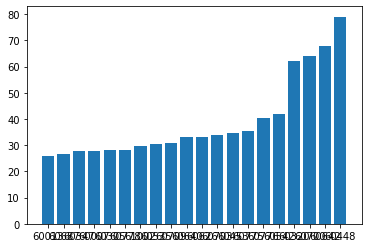

In [18]:
from matplotlib import pyplot as plt
x = dfSort['itemid'].values.tolist()
y = dfSort['stay_days'].values.tolist()

plt.bar(x,y)
plt.show()

In [21]:
dfGroup = spark.sql("""
select drgevents.itemid, description, type, count(*) as numCases  from delta.`/delta_MIMIC2/drgevents` as drgevents 
join delta.`/delta_MIMIC2/d_codeditems` as d_codeditems 
on drgevents.itemid = d_codeditems.itemid
group by drgevents.itemid, description, type
order by numCases desc
""").toPandas().head(10)
dfGroup

,itemid,description,type,numCases
0,60614,SEPTICEMIA AGE >17,HFCA_DRG,277
1,60691,RESPIRATORY SYSTEM DIAGNOSIS WITH VENTIL,HFCA_DRG,260
2,60272,G.I. HEMORRHAGE WITH CC,HFCA_DRG,160
3,60024,INTRACRANIAL HEMORRHAGE & STROKE WITH IN,HFCA_DRG,160
4,60181,MAJOR CARDIOVASCULAR PROCEDURES W CC,HFCA_DRG,141
5,60703,"TRACHEOSTOMY EXCEPT FOR FACE, MOUTH & NE",HFCA_DRG,131
6,60206,HEART FAILURE & SHOCK,HFCA_DRG,117
7,60490,RENAL FAILURE,HFCA_DRG,95
8,60681,EXTENSIVE O.R. PROCEDURE UNRELATED TO PR,HFCA_DRG,87
9,60002,CRANIOTOMY AGE >17 W CC,HFCA_DRG,85


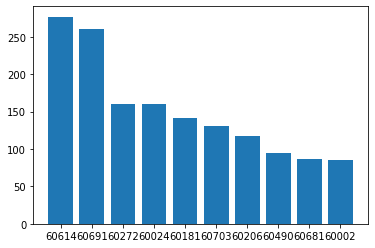

In [22]:
from matplotlib import pyplot as plt
x = dfGroup['itemid'].values.tolist()
y = dfGroup['numCases'].values.tolist()

plt.bar(x,y)
plt.show()

In [25]:
from datetime import datetime

df = spark.sql("""
select intime, outtime from delta.`/delta_MIMIC2/icustayevents`
""")

df = df.toPandas()
df["stay_days"] = df["outtime"].apply(lambda daytime: datetime.strptime(daytime, '%d/%m/%Y %H:%M:%S')) - df["intime"].apply(lambda daytime: datetime.strptime(daytime, '%d/%m/%Y %H:%M:%S'))
df["stay_days"] = df["stay_days"].apply(lambda timedelta : timedelta.days + 1 if timedelta.seconds//3600 >= 8 else timedelta.days)

dfGroup = df.groupby('stay_days', as_index=False)["intime"].count()
dfGroup

,stay_days,intime
0,0,270
1,1,1289
2,2,1130
3,3,789
4,4,490
...,...,...
69,99,2
70,104,1
71,118,2
72,154,1


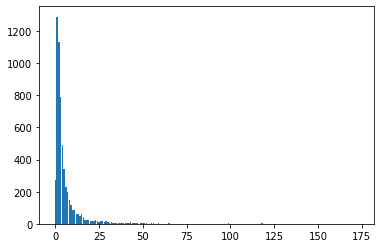

In [26]:
from matplotlib import pyplot as plt
x = dfGroup['stay_days']
y = dfGroup['intime'].values.tolist()

plt.bar(x,y)
plt.show()

In [27]:
df = spark.sql("""
select admit_dt, disch_dt from delta.`/delta_MIMIC2/admissions`
""")

df = df.toPandas()
df["stay_days"] = df["disch_dt"].apply(lambda daytime: datetime.strptime(daytime, '%d/%m/%Y %H:%M:%S')) - df["admit_dt"].apply(lambda daytime: datetime.strptime(daytime, '%d/%m/%Y %H:%M:%S'))
df["stay_days"] = df["stay_days"].apply(lambda timedelta : timedelta.days + 1 if timedelta.seconds//3600 >= 8 else timedelta.days)

dfGroup = df.groupby('stay_days', as_index=False)["disch_dt"].count()
dfGroup

,stay_days,disch_dt
0,0,87
1,1,272
2,2,286
3,3,370
4,4,361
...,...,...
94,138,1
95,146,1
96,154,1
97,167,1


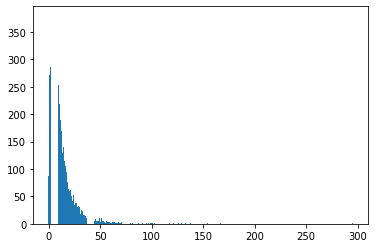

In [28]:
x = dfGroup['stay_days']
y = dfGroup['disch_dt'].values.tolist()

plt.bar(x,y)
plt.show()

In [29]:
spark.sql("""
select needICU , count(*) as numOfCases from
(select subject_id, count(*) as needICU from delta.`/delta_MIMIC2/icustayevents` group by subject_id) as group1 group by needICU order by numOfCases desc
""")

needICU,numOfCases
1,2943
2,664
3,207
4,78
5,47
6,16
7,10
8,8
9,4
10,3


In [37]:
df = spark.sql("""
select icustay_id, count(*) from delta.`/delta_MIMIC2/censusevents` where icustay_id is not null
group by icustay_id
having count(*) > 3

""")
df

icustay_id,count(1)
16980,4
32887,4
21148,4
16231,4
11865,4
19220,4
27660,4
19273,5
4054,5
27909,4


In [15]:
df = spark.sql("""
select description from delta.`/delta_MIMIC2/icd9` 
""")
df.show(truncate=False)

+--------------------------------------------------+
|description                                       |
+--------------------------------------------------+
|SECONDARY MALIGNANT NEOPLASM OF BRAIN AND SPINAL C|
|MALIGNANT NEOPLASM OF OTHER PARTS OF BRONCHUS OR L|
|CHRONIC OR UNSPECIFIED GASTRIC ULCER WITH HEMORRHA|
|HYPOSMOLALITY AND/OR HYPONATREMIA                 |
|CONGESTIVE HEART FAILURE UNSPECIFIED              |
|OTHER CONVULSIONS                                 |
|PURE HYPERCHOLESTEROLEMIA                         |
|UNSPECIFIED ESSENTIAL HYPERTENSION                |
|SUBENDOCARDIAL INFARCTION INITIAL EPISODE OF CARE |
|CONGESTIVE HEART FAILURE UNSPECIFIED              |
|CHRONIC AIRWAY OBSTRUCTION NOT ELSEWHERE CLASSIFIE|
|UNSPECIFIED GASTRITIS AND GASTRODUODENITIS WITH HE|
|ACUTE POSTHEMORRHAGIC ANEMIA                      |
|PNEUMONIA ORGANISM UNSPECIFIED                    |
|CORONARY ATHEROSCLEROSIS OF NATIVE CORONARY ARTERY|
|DIABETES MELLITUS WITHOUT COMPLICATION TYPE I